In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import remez, freqz
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import glob
import mne
import re
import random

import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

import multiprocessing
from functools import partial

# 1. Download data

#### Download Sleep-EDF expanded files via wget command. Took about 30 min on 5MB/s.

In [2]:
# %%time
# !wget -r -N -c -np https://physionet.org/files/sleep-edfx/1.0.0/

# 2. Explore data

In [3]:
f = glob.glob('./physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/*.edf')
f.sort()
f[:2]

['./physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf',
 './physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf']

In [4]:
# Read PSG file
psg_data = mne.io.read_raw_edf(
    input_fname='./physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf',
    stim_channel='Event marker',
    misc=['Temp rectal']
)

# Read annotations for PSG file
psg_annot = mne.read_annotations('./physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf')

# Set annotations for PSG file from read annotations file
psg_data.set_annotations(psg_annot, emit_warning=False)

Extracting EDF parameters from /home/leonardo/git/eeg-sleep-stage-detection/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~12 kB, data not loaded>

Using matplotlib as 2D backend.
Opening raw-browser...


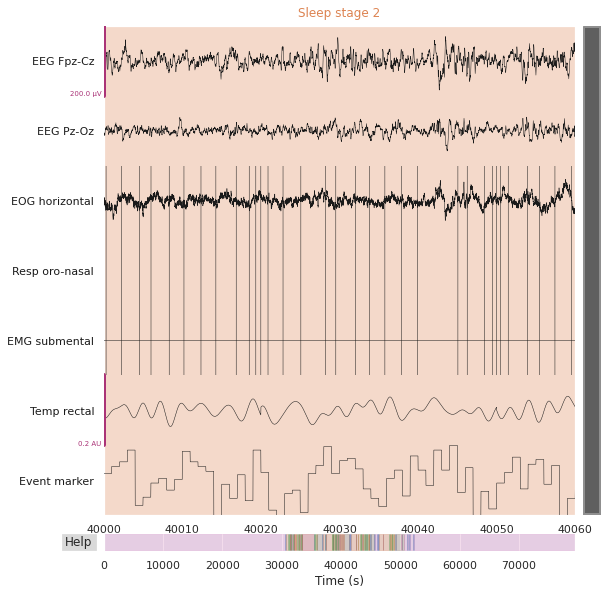

In [5]:
p = psg_data.plot(
    start=40000,
    duration=60,
    scalings=dict(
        eeg=1e-4,
        resp=1e3,
        eog=1e-5,
        emg=1e-7,
        misc=1e-1
    )
)

# 3. Get Filter coefficients for spectral decomposition

In [6]:
def get_spectral_decomposition_filters(
    waves_spectral_limits,
    transient_tolerance,
    waves_filter_orders,
    Fs
):
    
    # Get FIR coefficients for selecting each brain wave spectrum range
    waves_coeffs = {'original': [1]}
    for wave_name, wave_spectral_limits in waves_spectral_limits.items():
        # Lowpass filter for delta wave
        if wave_name=='delta':
            # Define LP specs
            filter_bands = [
                0,
                wave_spectral_limits['high'],
                wave_spectral_limits['high']*transient_tolerance['high'],
                Fs/2
            ]
            
            desired_response = [
                1,
                0
            ]
        else:
            # Define filter bands for Remez algorithm
            filter_bands = [
                0,
                transient_tolerance['low']*wave_spectral_limits['low'],
                wave_spectral_limits['low'],
                wave_spectral_limits['high'],
                wave_spectral_limits['high']*transient_tolerance['high'],
                Fs/2
            ]
            
            # Desired response of bandpass filter transfer fn
            desired_response = [
                0,
                1,
                0
            ]
        
        # Get FIR bandpass coeffs from remez algorithm
        coeffs = remez(
            numtaps=waves_filter_orders[wave_name],
            bands=filter_bands,
            desired=desired_response,
            fs=Fs
        )
        
        # Save coefficients
        waves_coeffs.update({wave_name: coeffs})
    
    return waves_coeffs
        

In [7]:
# Filter order plus one
ORDER = 100

# Sampling frequency
Fs = 100

# Spectral ranges for specific brain waves
waves_spectral_limits = {
    'delta': {
        'low': 0.5,
        'high': 4
    },
    'theta': {
        'low': 4,
        'high': 8
    },
    'alpha': {
        'low': 8,
        'high': 15
    },
    'beta': {
        'low': 15,
        'high': 31
    },
    'gamma': {
        'low': 31,
        'high': 45
    },
}

# Filter orders for specific brain waves
waves_filter_orders = {
    'delta': 192,
    'theta': 192,
    'alpha': 100,
    'beta': 100,
    'gamma': 100,
}

# Tolerance for transition bands between stopbands and passband
trans_tolerance = {
    'low': 0.9,
    'high': 1.1
}

waves_coeffs = get_spectral_decomposition_filters(
    waves_spectral_limits=waves_spectral_limits,
    transient_tolerance=trans_tolerance,
    waves_filter_orders=waves_filter_orders,
    Fs=Fs
)

In [8]:
def plot_filter_responses(
    waves_coeffs,
    Fs,
    n_frequency_points=512
):
    
    # Get number of waves
    n_waves = len(waves_coeffs.keys())
    
    # Initialize figure with one subplot per wave band
    fig, axs = plt.subplots(
        nrows=n_waves,
        ncols=1,
        figsize=(20,8*n_waves)
    )
    
    # Plot each filter's spectral response
    iterator = zip(
        list(waves_coeffs.keys()),
        axs
    )
    for wave, ax in iterator:
        # Get filter coefficients
        wave_coeffs = waves_coeffs[wave]
        
        # Get frequency response
        W, H = freqz(
            b=wave_coeffs,
            a=[1],
            worN=n_frequency_points
        )
        
        ###########################
        # Plot frequency response #
        ###########################
        
        # X axis frequencies in Hz
        plot_x = [0.5*Fs*w/np.pi for w in W]
        
        # Y axis magnitude response in dB
        plot_y = [20*np.log10(np.abs(h)) for h in H]
        
        # Create plot
        ax.plot(
            plot_x,
            plot_y
        )
        ax.set_title('Filter - {} wave'.format(wave))
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Magnitude response (dB)')

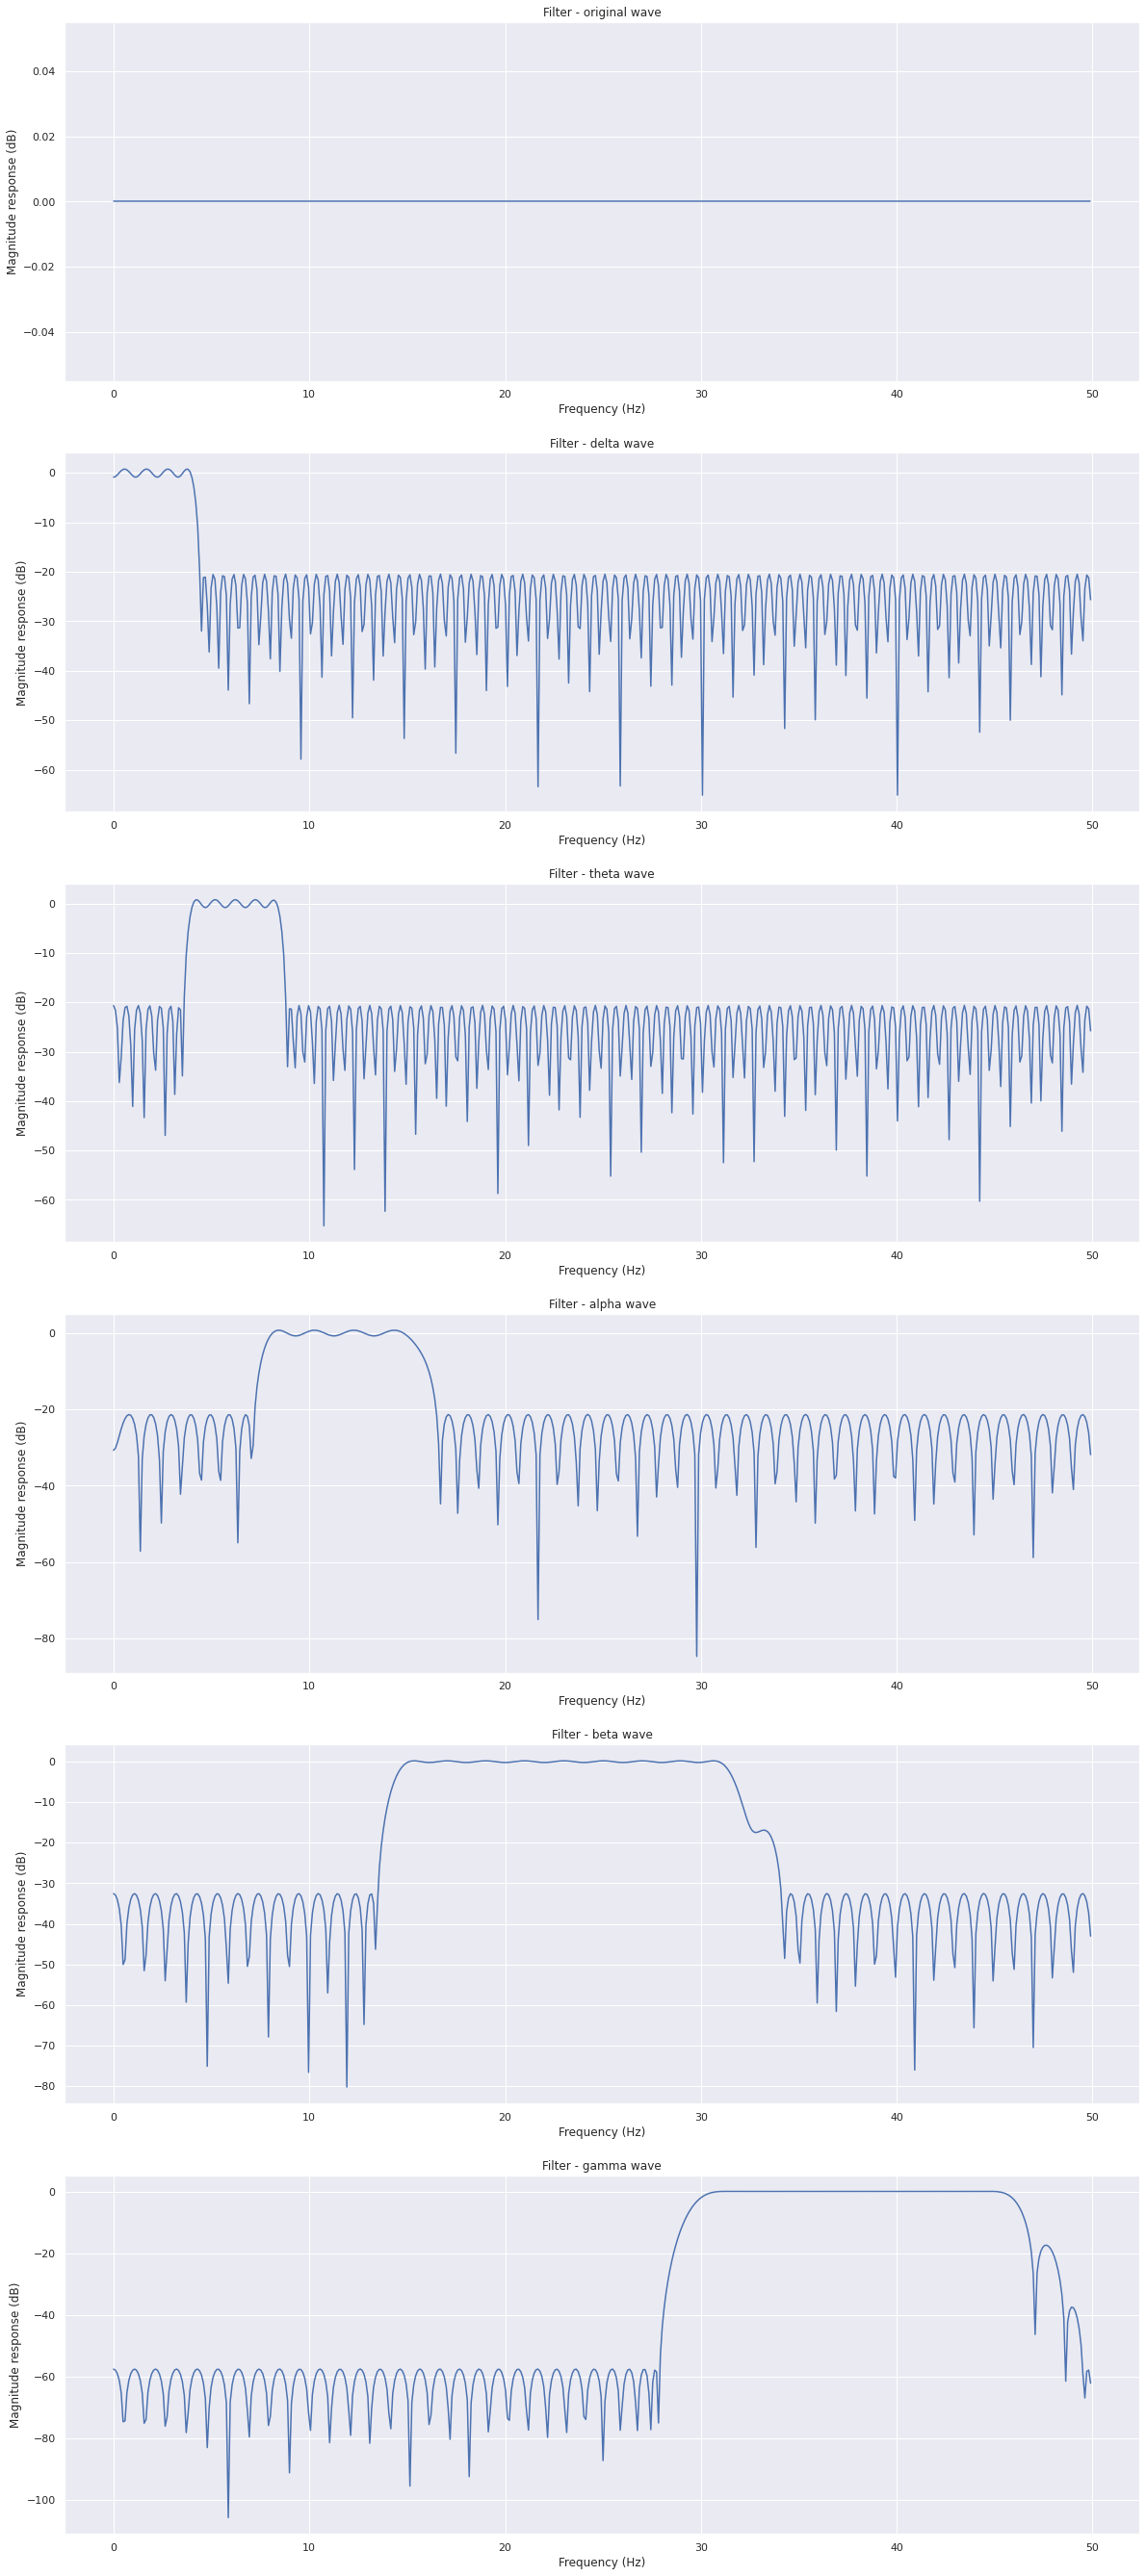

In [9]:
plot_filter_responses(
    waves_coeffs=waves_coeffs,
    Fs=Fs
)

In [10]:
def plot_filtered_sample(
    sample_sig,
    sample_label,
    waves_coeffs,
    Fs
):
    
    # Get number of waves
    n_waves = len(waves_coeffs.keys())
    
    # Initialize figure with one subplot per wave band
    fig, axs = plt.subplots(
        nrows=n_waves,
        ncols=1,
        figsize=(20,8*n_waves)
    )
    
    # Plot each filter's spectral response
    iterator = zip(
        list(waves_coeffs.keys()),
        axs
    )
    for wave, ax in iterator:
        # Get filter coefficients
        wave_coeffs = waves_coeffs[wave]
        
        # Get filtered signal
        filtered = sp.signal.lfilter(
            b=wave_coeffs,
            a=[1],
            x=sample_sig
        )
        
        ###########################
        # Plot frequency response #
        ###########################
        
        # X axis frequencies in Hz
        plot_x = [i/Fs for i in range(len(filtered))]
        
        # Y axis magnitude response in dB
        plot_y = filtered
        
        # Create plot
        ax.plot(
            plot_x,
            plot_y
        )
        ax.set_title('{} wave'.format(wave))
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Signal')

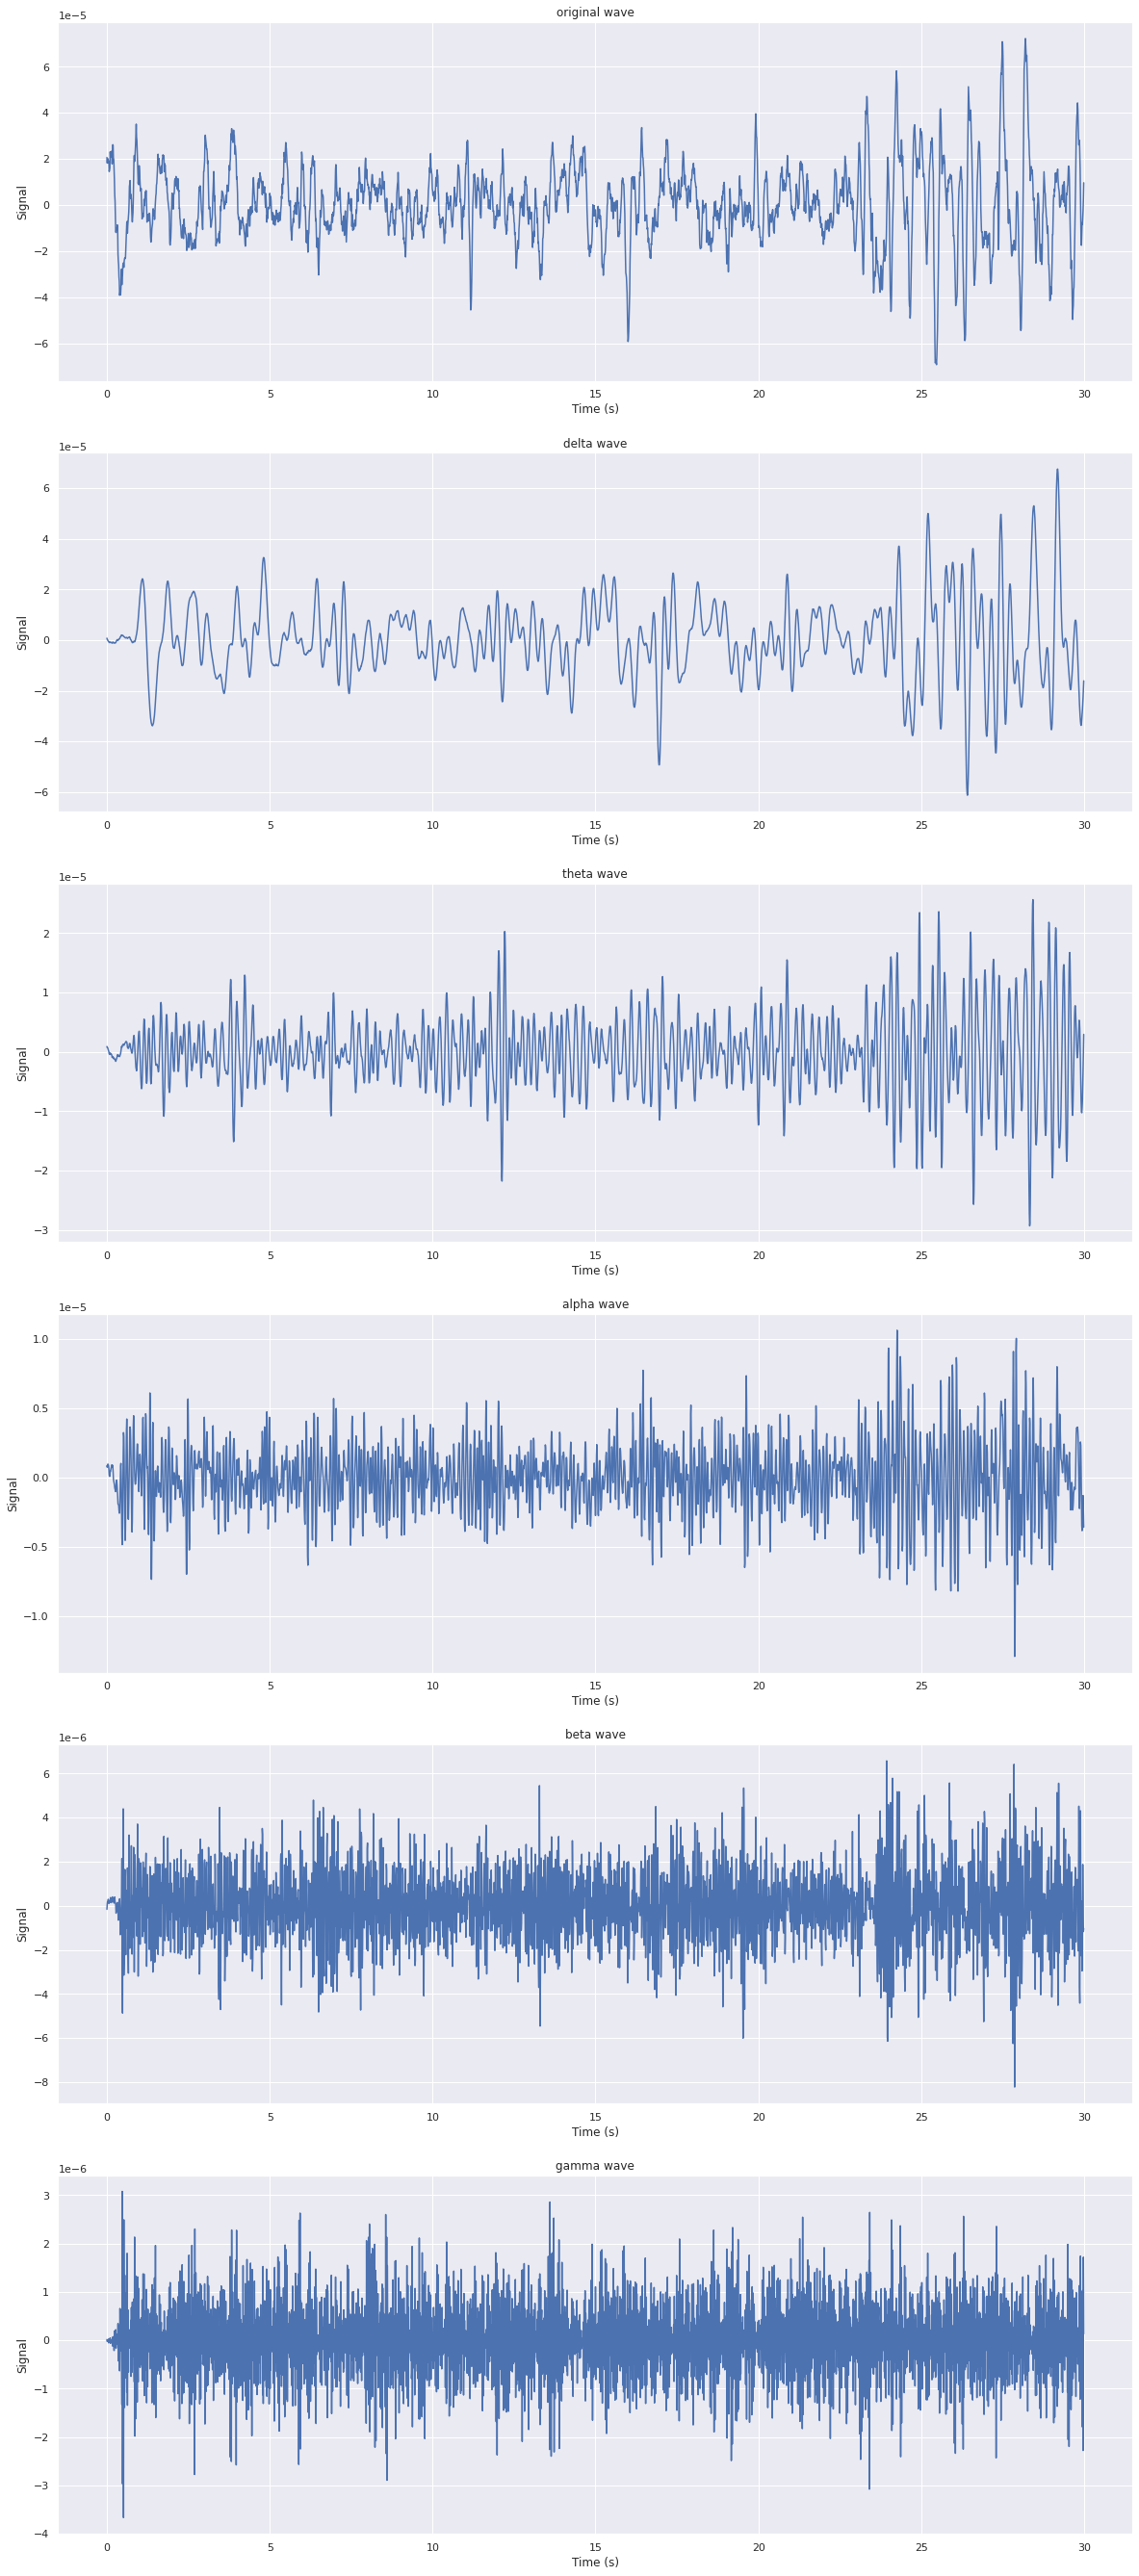

In [11]:
# Get sample signal, behavior onsets and labels
eeg_fpz_cz_sig = psg_data['EEG Fpz-Cz'][0][0]
onsets = psg_annot.onset
labels = psg_annot.description

# Get windowing indexes and label
used_segment=2
wdw_size = 3000
wdw_start = int(Fs*onsets[used_segment])
wdw_end = int(wdw_start + wdw_size)
sample_label=labels[used_segment]

# Plot filtered waves
plot_filtered_sample(
    sample_sig=eeg_fpz_cz_sig[wdw_start:wdw_end],
    sample_label=sample_label,
    waves_coeffs=waves_coeffs,
    Fs=Fs
)

# 4. Create Features

In [12]:
def map_subjects_files(filepaths):
    # Get identifier for subject+night for each file
    subj_night = list(
        set([re.search('SC4[0-9]{3}', x).group(0) for x in filepaths])
    )
    subj_night.sort()

    # Initialize dict with subjects as keys. Values will be array of arrays.
    subj_files = {s[3:5]: [] for s in subj_night}

    # Iterate through nights to group data+label files for each night
    for sn in subj_night:
        # Get subject
        subj = sn[3:5]
        # Get pair of data+label files corresponding to subject-night
        sn_pair = [f for f in filepaths if sn in f]
        # Update dict values
        subj_files[subj].append(sn_pair)
    
    return subj_files


def katz_fractal_dimension(signal):
    
    # Get length of signal
    N = len(signal)
    
    # Define lambda function for euclidean distance
    euclidean_distance = lambda x1, x2: np.linalg.norm(np.subtract(x1, x2))
    
    # Get (x,y) coordinates for wave points and iterator that contains successive (x,y) pairs
    coordinates = [
        [i, x] for i, x in zip(range(len(signal)), signal)
    ]
    iterator = zip(
        coordinates[:-1],
        coordinates[1:]
    )
    
    # Get sum of distances between successive points
    L = np.sum([
        euclidean_distance(
            x1=x1,
            x2=x2
        ) for x1, x2 in iterator
    ])
    
    # Get maximum distance between first point and any other point, consider only points halfway on for 
    # less computational complexity
    x0 = coordinates[0]
    halfway = N//2
    d = np.max(
        [euclidean_distance(x1=x0, x2=x) for x in coordinates[halfway:]]
    )
    
    # Get katz fractal dimension
    katz_fd = np.log10(N)/(np.log10(N*d/L))
    
    return katz_fd


def petrosian_fractal_dimension(signal):
    
    # Get length of signal
    N = len(signal)
    
    # Differentiate signal
    signal_diff = np.diff(signal)
    
    # Get adjacent diffs in pairs for analysis
    adj_diffs = zip(
        signal_diff[:-1],
        signal_diff[1:]
    )
    
    # Get number of sign changes
    M = np.sum([
       1 for x1, x2 in adj_diffs if np.sign(x1) != np.sign(x2)
    ])
    
    # Get Petrosian fractal dimension
    petrosian_fd = np.log10(N)/np.log10(np.square(N)/(N+0.4*M))
    
    return petrosian_fd


def higuchi_fractal_dimension(signal):
    
    # Get length of signal
    N = len(signal)
    
    # Get range of k's which will be evaluated
    eval_ks = range(1, 7)
    
    L_k = []
    # Iterate over k's
    for k in eval_ks:
        L_m_k = []
        # Iterate over starting points
        for m in range(1, k+1):
            # Get indices which will be evaluated in summation
            eval_idxs = range(1, int((N-m)/k))
            
            # Get sum of distances between k-separated points
            length_m_k = np.sum([
                np.abs(signal[m + i*k] - signal[m + (i-1)*k]) for i in eval_idxs
            ])
            
            # Normalize to obtain L_m(k)
            length_m_k *= (N-1)/(np.square(k)*(N-m)/k)
            
            # Append to L_m_k
            L_m_k.append(length_m_k)
        
        # Append average over m's to L(k)
        L_k.append(
            np.mean(L_m_k)
        )
        
    # Get slope of best-fitting linear function through log(1/k);log(L/k)
    higuchi_fd = np.polyfit(
        x=[np.log10(1/k) for k in eval_ks],
        y=np.log10(L_k),
        deg=1
    )[0]
    
    return higuchi_fd


def hjorth_mobility(signal):
    return np.std(np.diff(signal))/np.std(signal)
    
def hjorth_complexity(signal):
    return hjorth_mobility(np.diff(signal))/hjorth_mobility(signal)
            

def get_window_features(
    wave,
    filtered_signal,
    scaler
):
    
    # Unscaled features
    if wave=='original':
        # Save raw segment only for original signal
        filtered_features = pd.DataFrame(
            index=[0],
            data={
                'windowed_segment_{}'.format(wave): [filtered_signal],
                'filtered_{}_energy'.format(wave): [np.var(filtered_signal)]
            }
        )
    else:
        filtered_features = pd.DataFrame(
            index=[0],
            data={
                'filtered_{}_energy'.format(wave): [np.var(filtered_signal)]
            }
        )
        
    # Scale signal
    scaled_signal = scaler().fit_transform(
        filtered_signal.reshape(-1, 1)
    ).reshape(
        (len(filtered_signal),)
    )
    
    # Get scaled features
    filtered_features['filtered_{}_max'.format(wave)] = np.max(scaled_signal)
    filtered_features['filtered_{}_min'.format(wave)] = np.min(scaled_signal)
    filtered_features['filtered_{}_skew'.format(wave)] = sp.stats.skew(scaled_signal)
    filtered_features['filtered_{}_kurtosis'.format(wave)] = sp.stats.kurtosis(scaled_signal)
    filtered_features['filtered_{}_entropy'.format(wave)] = sp.stats.entropy(
        pk=np.histogram(scaled_signal)[0]/np.sum(np.histogram(scaled_signal)[0])
    )
    filtered_features['filtered_{}_katz_fd'.format(wave)] = katz_fractal_dimension(scaled_signal)
    filtered_features['filtered_{}_petrosian_fd'.format(wave)] = petrosian_fractal_dimension(scaled_signal)
    filtered_features['filtered_{}_higuchi_fd'.format(wave)] = higuchi_fractal_dimension(scaled_signal)
    filtered_features['filtered_{}_hjorth_mobility'.format(wave)] = hjorth_mobility(scaled_signal)
    filtered_features['filtered_{}_hjorth_complexity'.format(wave)] = hjorth_complexity(scaled_signal)
    
    return filtered_features



def window_state_signal(
    label_sig,
    label,
    waves_coeffs,
    scaler
):
    
    # Get filtered signal for each spectrum range specification
    filtered_signals = {
        wave: sp.signal.lfilter(
            b=coeffs,
            a=[1],
            x=label_sig
        ) for wave, coeffs in waves_coeffs.items()
    }
    
    # Get number of samples which will be generated
    n_samples = len(label_sig)//WINDOW_SIZE
    
    # Get windows from original signal, according to spectrum identification
    samples = pd.DataFrame()
    for i in range(n_samples):
        # Subsample Wake samples
        if LABEL_MAP[label]=='W':
            use_sample = np.random.choice(
                a=[True, False],
                size=None,
                p=[1/WAKE_SUBSAMPLING_FACTOR, 1-1/WAKE_SUBSAMPLING_FACTOR]
            )
            if not use_sample:
                continue
            
        window_df = pd.DataFrame()
        for wave in waves_coeffs.keys():
            window_df = pd.concat(
                [
                    window_df,
                    get_window_features(
                        wave=wave,
                        filtered_signal=filtered_signals[wave][WINDOW_SIZE*i: WINDOW_SIZE*(i+1)],
                        scaler=scaler
                    )
                ],
                axis=1
            )
            
        # Add label column
        window_df['label'] = LABEL_MAP[label]
        
        # Add relative energy columns
        energy_cols = [c for c in window_df.columns if 'energy' in c]
        original_energy_col = [c for c in energy_cols if 'original' in c][0]
        waves_energy_cols = [c for c in energy_cols if 'original' not in c]
        for c in waves_energy_cols:
            window_df[c+'_relative'] = window_df[c]/window_df[original_energy_col]
        
        # Drop absolute energy cols
        window_df = window_df.drop(columns=energy_cols)
        
        samples = pd.concat(
            [
                samples,
                window_df
            ],
            axis=0
        )
    
    return samples.reset_index(drop=True)

def process_subj_night(
    subj_night_files,
    waves_coeffs,
    scaler
):
    
    # Get data and labels files
    psg_file = [f for f in subj_night_files if 'PSG' in f][0]
    annot_file = [f for f in subj_night_files if 'Hypnogram' in f][0]
    
    # Read PSG file
    psg_data = mne.io.read_raw_edf(
        psg_file,
        stim_channel='Event marker',
        misc=['Temp rectal'],
        verbose=False
    )
    
    # Read annotations file
    psg_annot = mne.read_annotations(annot_file)
    
    # Obtain Fpz-Cz signal from PSG
    psg_fpz_cz = psg_data['EEG Fpz-Cz'][0][0]
    
    # Get labels, label onsets and durations
    onsets = [int(100*o) for o in psg_annot.onset[:-1]]
    durations = [int(100*d) for d in psg_annot.duration[:-1]]
    labels = psg_annot.description[:-1]
    
    # Iterate through marked labels
    iterator = zip(
        onsets,
        durations,
        labels
    )
    subj_night_samples = pd.DataFrame()
    for onset, dur, label in iterator:
        # Exclude other labels
        if label not in LABEL_MAP.keys():
            if label not in ['Movement time', 'Sleep stage ?']:
                print('Excluded label: {}, Duration: {} seconds'.format(label, dur/100))
            continue

        # Window signal duration corresponding to label
        label_sig = psg_fpz_cz[onset:onset+dur]

        if len(label_sig) >= WINDOW_SIZE:
            # Window signal to obtain samples if segment is longer than WINDOW_SIZE
            segment_samples = window_state_signal(
                label_sig=label_sig,
                label=label,
                waves_coeffs=waves_coeffs,
                scaler=scaler
            )
        elif len(label_sig) < WINDOW_SIZE:
            segment_samples = pd.DataFrame(
                index=[0],
                data={
                    'segment': [np.nan],
                    'label': [LABEL_MAP[label]]
                }
            )

        # Append to subj_night_samples
        subj_night_samples = pd.concat(
            [
                subj_night_samples,
                segment_samples
            ],
            axis=0
        )

    return subj_night_samples.reset_index(drop=True)       


def process_subject(
    waves_coeffs,
    scaler,
    subj_item
):
    
    subj = subj_item[0]
    subj_files = subj_item[-1]
    
    subj_samples = pd.DataFrame()
    for f in subj_files:
        # Process one night of subject
        subj_night_samples = process_subj_night(
            subj_night_files=f,
            waves_coeffs=waves_coeffs,
            scaler=scaler
        )
        
        # Append to subj_samples
        subj_samples = pd.concat(
            [
                subj_samples,
                subj_night_samples
            ],
            axis=0
        )
    
    # Add subject information
    subj_samples['subject'] = subj
        
    return subj_samples.reset_index(drop=True)

def process_dataset(
    waves_coeffs,
    subj_files,
    scaler
):
    
    # Fixate waves coeffs argument
    subj_exec_fn = partial(
        process_subject,
        waves_coeffs,
        scaler
    )
    
    # Distributed execution for each subject
    with multiprocessing.Pool(NJOBS) as p:
        results = p.map(
            subj_exec_fn,
            subj_files.items()
        )
    
    # Unify dataframes
    proc_samples = pd.DataFrame()
    for subj_samples in results:
        proc_samples = pd.concat(
            [
                proc_samples,
                subj_samples
            ],
            axis=0
        )
        
    return proc_samples.reset_index(drop=True)


In [13]:
%%time
SUBJ_SAMPLING_FACTOR=1/4
WAKE_SUBSAMPLING_FACTOR = 3
LABEL_MAP = {
    'Sleep stage W': 'W',
    'Sleep stage 1': 'N1',
    'Sleep stage 2': 'N2',
    'Sleep stage 3': 'N3',
    'Sleep stage 4': 'N3',
    'Sleep stage R': 'R'
}
WINDOW_SIZE = 3000
FS = 100
FILEPATHS_SPEC = './physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/*.edf'
NJOBS = 11

subj_files = map_subjects_files(
    filepaths=glob.glob(FILEPATHS_SPEC)
)

subjects = list(subj_files.keys())
sampled_subjects = random.sample(subjects, int(SUBJ_SAMPLING_FACTOR*len(subjects)))
sampled_subj_files = {k: v for k, v in subj_files.items() if k in sampled_subjects}

proc_df = process_dataset(
    waves_coeffs=waves_coeffs,
    subj_files=sampled_subj_files,
    scaler=StandardScaler
)

proc_df.head(10)

CPU times: user 2.02 s, sys: 2.12 s, total: 4.14 s
Wall time: 1h 2min 39s


,windowed_segment_original,filtered_original_max,filtered_original_min,filtered_original_skew,filtered_original_kurtosis,filtered_original_entropy,filtered_original_katz_fd,filtered_original_petrosian_fd,filtered_original_higuchi_fd,filtered_original_hjorth_mobility,...,filtered_gamma_higuchi_fd,filtered_gamma_hjorth_mobility,filtered_gamma_hjorth_complexity,label,filtered_delta_energy_relative,filtered_theta_energy_relative,filtered_alpha_energy_relative,filtered_beta_energy_relative,filtered_gamma_energy_relative,subject
0,"[2.6191208791208796e-05, 2.0872527472527478e-0...",4.777147,-4.662051,0.229656,2.663647,1.475891,1.011122,1.026813,1.659726,0.555428,...,2.116032,1.860817,1.008212,W,0.915395,0.081257,0.034128,0.044655,0.047385,03
1,"[8.301098901098907e-06, 8.591208791208797e-06,...",3.385610,-3.707716,0.108956,0.727185,1.754590,1.003978,1.024404,1.455867,0.267022,...,2.122473,1.832689,1.007022,W,0.923668,0.083527,0.016930,0.010381,0.007419,03
2,"[-5.140659340659334e-06, -2.5296703296703228e-...",4.072689,-4.695993,-0.785224,3.566616,1.480800,1.009568,1.026756,1.624702,0.458427,...,2.116077,1.846262,1.006884,W,0.903374,0.107439,0.028003,0.033320,0.028710,03
3,"[-6.687912087912081e-06, -2.0879120879120182e-...",4.320301,-4.949751,-0.245896,1.901005,1.472833,1.011011,1.026799,1.635419,0.535752,...,2.110811,1.864542,1.005816,W,0.772909,0.094775,0.034996,0.044838,0.038043,03
4,"[-9.782417582417576e-06, 3.079120879120886e-06...",3.776634,-3.319637,0.076504,1.490153,1.710445,1.007601,1.026998,1.579987,0.384840,...,2.116479,1.839721,1.007584,W,0.946195,0.105730,0.028554,0.022300,0.019581,03
5,"[1.5650549450549455e-05, 2.4160439560439566e-0...",3.850069,-4.307239,-0.410919,2.720082,1.533279,1.007758,1.026500,1.581847,0.385561,...,2.119893,1.842536,1.007008,W,0.831938,0.095902,0.026073,0.021858,0.018977,03
6,"[3.054285714285715e-05, 3.8569230769230774e-05...",4.989628,-4.749030,-0.017559,1.382588,1.451825,1.018508,1.027992,1.769981,0.741168,...,2.112233,1.834242,1.007496,W,0.736553,0.060294,0.043268,0.093943,0.086767,03
7,"[-1.809890109890109e-05, -6.881318681318674e-0...",3.916783,-3.912989,-0.405554,1.890773,1.625371,1.006852,1.025957,1.540330,0.366352,...,2.106187,1.851823,1.006587,W,0.905315,0.111590,0.029424,0.019405,0.016800,03
8,"[3.465934065934073e-06, 3.659340659340666e-06,...",5.421377,-4.974218,-1.008831,3.947340,1.325011,1.010073,1.026542,1.623224,0.480651,...,2.112430,1.854362,1.007382,W,0.790100,0.115330,0.034115,0.034057,0.032460,03
9,"[-3.303296703296697e-06, 8.397802197802205e-06...",3.795927,-3.812191,-0.250435,1.098821,1.673415,1.023986,1.028444,1.778588,0.782306,...,2.106928,1.851916,1.006558,W,0.712511,0.121255,0.046654,0.089881,0.098639,03


In [14]:
proc_df.label.value_counts()

W     23765
N2    17574
R      7009
N1     5546
N3     3672
Name: label, dtype: int64

# 4. Feature Selection

In [15]:
# Declare estimator
clf = RandomForestClassifier(
    criterion='gini',
    max_features='sqrt',
    max_samples=0.9
)

# Declare model selector
selector = GridSearchCV(
    estimator=clf,
    param_grid={
        'n_estimators': [1000, 2000],
        'min_impurity_decrease': [0.00001, 0.000005]
    },
    n_jobs=11
    
)

In [16]:
%%time
# Get features and labels
X = proc_df.drop(columns=['windowed_segment_original', 'label', 'subject'])
y = proc_df['label']

# Fit GridSearchCV 
selector.fit(
    StandardScaler().fit_transform(X),
    y
)

CPU times: user 5min 58s, sys: 527 ms, total: 5min 59s
Wall time: 33min 22s


GridSearchCV(estimator=RandomForestClassifier(max_features='sqrt',
                                              max_samples=0.9),
             n_jobs=11,
             param_grid={'min_impurity_decrease': [1e-05, 5e-06],
                         'n_estimators': [1000, 2000]})

In [17]:
# Get results from GridSearchCV
selector_results = pd.DataFrame(
    selector.cv_results_
).sort_values(
    by='rank_test_score',
    ascending=True
).reset_index(
    drop=True
)
selector_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_impurity_decrease,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,495.749168,10.467961,2.274006,0.125018,0.00001,1000,"{'min_impurity_decrease': 1e-05, 'n_estimators...",0.805194,0.792495,0.684444,0.691740,0.734735,0.741721,0.049869,1
1,728.907307,88.149721,3.312662,0.162381,0.000005,2000,"{'min_impurity_decrease': 5e-06, 'n_estimators...",0.806583,0.793711,0.685920,0.689742,0.732563,0.741704,0.050615,2
2,981.181082,18.644173,4.703750,0.102963,0.00001,2000,"{'min_impurity_decrease': 1e-05, 'n_estimators...",0.805107,0.793277,0.686789,0.689655,0.732737,0.741513,0.049969,3
3,517.606439,6.343975,2.188645,0.206862,0.000005,1000,"{'min_impurity_decrease': 5e-06, 'n_estimators...",0.805888,0.791540,0.686181,0.690003,0.732303,0.741183,0.049892,4


In [18]:
# Get best model from GridSearchCV
model=selector.best_estimator_

# Get feature importances from best_model
importances = pd.DataFrame(
    data={
        'variable': X.columns,
        'importance': model.feature_importances_,
    }
).sort_values(
    by='importance',
    ascending=False
).reset_index(
    drop=True
)
importances

,variable,importance
0,filtered_beta_hjorth_mobility,0.063915
1,filtered_beta_hjorth_complexity,0.055496
2,filtered_beta_petrosian_fd,0.042339
3,filtered_alpha_hjorth_complexity,0.041344
4,filtered_theta_petrosian_fd,0.034420
...,...,...
60,filtered_alpha_skew,0.005635
61,filtered_beta_entropy,0.005634
62,filtered_beta_min,0.005428
63,filtered_theta_max,0.005380


In [24]:
importances.tail(50)

,variable,importance
15,filtered_gamma_katz_fd,0.019478
16,filtered_theta_katz_fd,0.017643
17,filtered_original_higuchi_fd,0.017520
18,filtered_gamma_petrosian_fd,0.017501
19,filtered_beta_higuchi_fd,0.017354
20,filtered_alpha_higuchi_fd,0.016503
21,filtered_alpha_hjorth_mobility,0.016187
22,filtered_beta_katz_fd,0.016137
23,filtered_delta_hjorth_complexity,0.015911
24,filtered_theta_kurtosis,0.015323
